# Look at results of NODE training

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [31]:
paths = [
    "seed_1234_sample_rate_1_lr_0.1_n_epochs_200_hidden_dim_2_patience_50_log.pkl",
    "seed_1234_sample_rate_5_lr_0.1_n_epochs_200_hidden_dim_2_patience_50_log.pkl",
    "seed_1234_sample_rate_10_lr_0.1_n_epochs_200_hidden_dim_2_patience_50_log.pkl"
]

In [32]:
logs = []

for path in paths: 
    with open(path, 'rb') as file:
        logs.append(pickle.load(file))

In [33]:
def get_run_time(log):
    return np.sum(log["times"])

def get_stop_flag(log):
    return log["stopping_criteria"]

In [34]:
run_times = [get_run_time(log) for log in logs]

In [35]:
np.sum(run_times)/60

72.71438904205958

In [36]:
[get_stop_flag(log) for log in logs]

['max-epochs', 'early-stoppage', 'early-stoppage']

In [37]:
pat = logs[1]["patience_hist"]

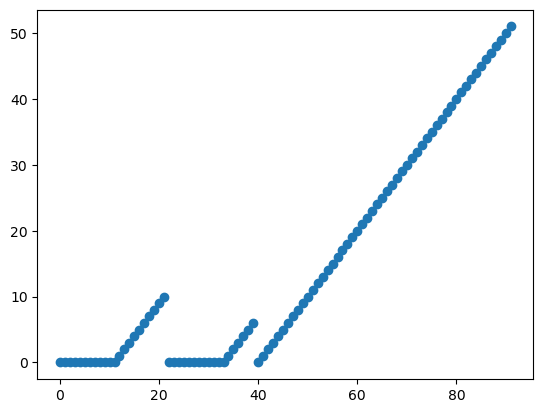

In [38]:
plt.scatter(np.arange(len(pat)),pat)
plt.show()

([<matplotlib.lines.Line2D at 0x2b234b4084d0>],
 [0.033764518797397614,
  0.03470364212989807,
  0.03219924122095108,
  0.03182445466518402,
  0.031870074570178986],
 0.017710693180561066)

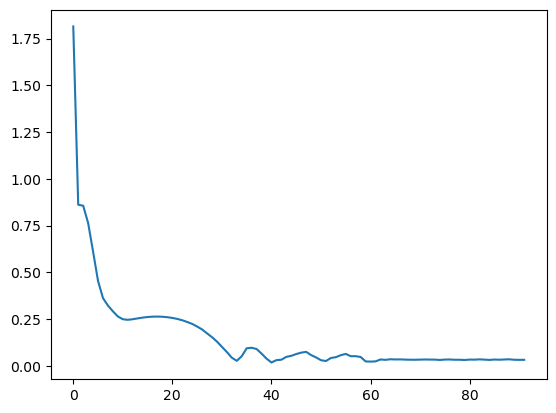

In [39]:
plt.plot(logs[1]['losses']), logs[1]['losses'][-5:], np.min(logs[1]["losses"])

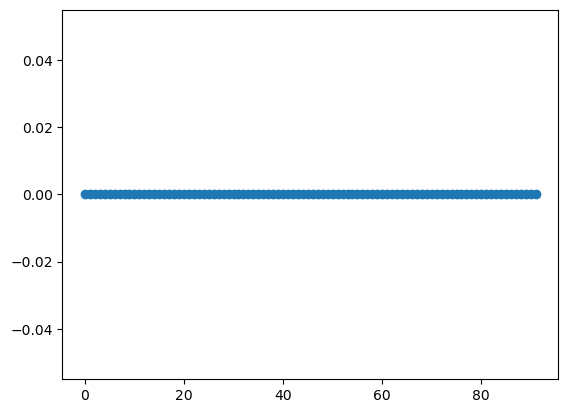

In [40]:
fails = logs[1]["method_failures"]
plt.scatter(np.arange(len(fails)), fails)
plt.show()

## Look at Learned $g$ compared to data

In [41]:
from stabnode.node import set_global_seed, _load_model_opt
from data.hysteresis import simulate_steady_state
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [42]:
# parameters from experiment
seed = 1234
sample_rate = 1

In [43]:
# Load data in the same way 
def load_data(seed, sample_rate):
    set_global_seed(seed = seed)
    
    lam_start = -1 
    lam_end = 1
    
    n_points = 250
    
    lam_increase = np.linspace(lam_start,lam_end, n_points)
    lam_decrease = np.linspace(lam_end, lam_start, n_points)
    
    x0=-1
    
    simulate_time = (0.,50.)
    
    x_increase = simulate_steady_state(lam_increase, x0, simulate_time,show_progress=True)
    x_decrease = simulate_steady_state(lam_decrease, x_increase[-1],simulate_time, show_progress=True)
    
    X = np.hstack((x_increase, x_decrease))
    lam = np.hstack((lam_increase, lam_decrease))
    repeat = 2
    
    for _ in range(repeat):
        X = np.hstack((X,X))
        lam = np.hstack((lam, lam))
    
    tau = torch.arange(0,len(lam),device=device)
    t = (tau+1)*simulate_time[-1]
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    X_scaled = scaler.fit_transform(X.reshape(-1,1))
    X_scaled = torch.tensor(X_scaled,dtype=torch.float32, device=device)
    
    # sample_rate = 10
    tau_train = tau[::sample_rate]
    X_train = X_scaled[tau_train]
    lam_train = lam[tau_train]

    def lam_func(tau):
        idx = int(tau) % len(lam)
        return torch.tensor(lam[idx],dtype=torch.float32, device=device)
    
    return X, lam, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func

In [44]:
model_paths = [
    "seed_1234_sample_rate_1_lr_0.1_n_epochs_200_hidden_dim_2_patience_50.pt",
    "seed_1234_sample_rate_5_lr_0.1_n_epochs_200_hidden_dim_2_patience_50.pt",
    "seed_1234_sample_rate_10_lr_0.1_n_epochs_200_hidden_dim_2_patience_50.pt"
]

seeds = [1234,1234,1234]
sample_rates = [1,5,10]
lrs = [0.1,0.1, 0.1]

In [45]:
def g_true(x,lam):
    return (1/x)*((lam / x)  + 1)

def f_true(x):
    return -x**2

In [46]:
# model, opt, epoch, loss = _load_model_opt(model_path[2])

# X, lam, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func = load_data(seed=1234,sample_rate = 10)
# 

In [47]:
def evaluate_model(model, X, lam, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func):
    g = model.g
    f = model.f
    
    g.eval()
    f.eval()
    
    g_true_out = []
    g_pred_out = []
    
    f_true_out = []
    f_pred_out = []
    
    for tau_i in tau:
    
        lam_i = lam_func(tau_i).reshape(-1,1)
        xi = X_scaled[tau_i].reshape(-1,1)
        xi_unscaled = X[tau_i].reshape(-1,1)
    
        g_true_out.append(g_true(xi_unscaled,lam_i.numpy()))
        f_true_out.append(f_true(xi_unscaled))
    
        with torch.no_grad():
            g_pred_out.append(g(xi,lam_i).detach().cpu().numpy())
            f_pred_out.append(f(xi).detach().cpu().numpy())
    
    g_true_out = np.array(g_true_out).reshape(-1)
    g_pred_out = np.array(g_pred_out).reshape(-1)
    
    f_true_out = np.array(f_true_out).reshape(-1)
    f_pred_out = np.array(f_pred_out).reshape(-1)
    
    finite_idx = np.isfinite(g_true_out)
    np.count_nonzero(~finite_idx)
    g_true_scaled = scaler.transform(g_true_out[finite_idx].reshape(-1,1)).reshape(-1)
    
    L2_rel_err = np.linalg.norm(g_true_scaled - g_pred_out) / np.linalg.norm(g_true_scaled)

    return g_true_scaled, g_pred_out, tau_train, X_train, L2_rel_err
    


In [48]:
true = []
pred = []
tau = []
train = []
l2 = []

for path, seed, sample_rate in zip(model_paths,seeds, sample_rates):
    model, opt, epoch, loss = _load_model_opt(path)
    g_true_scaled, g_pred_out, tau_train, X_train, L2_rel_err= evaluate_model(model, *load_data(seed=seed,sample_rate=sample_rate))
    true.append(g_true_scaled)
    pred.append(g_pred_out)
    tau.append(tau_train)
    train.append(X_train)
    l2.append(L2_rel_err)
    
    

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

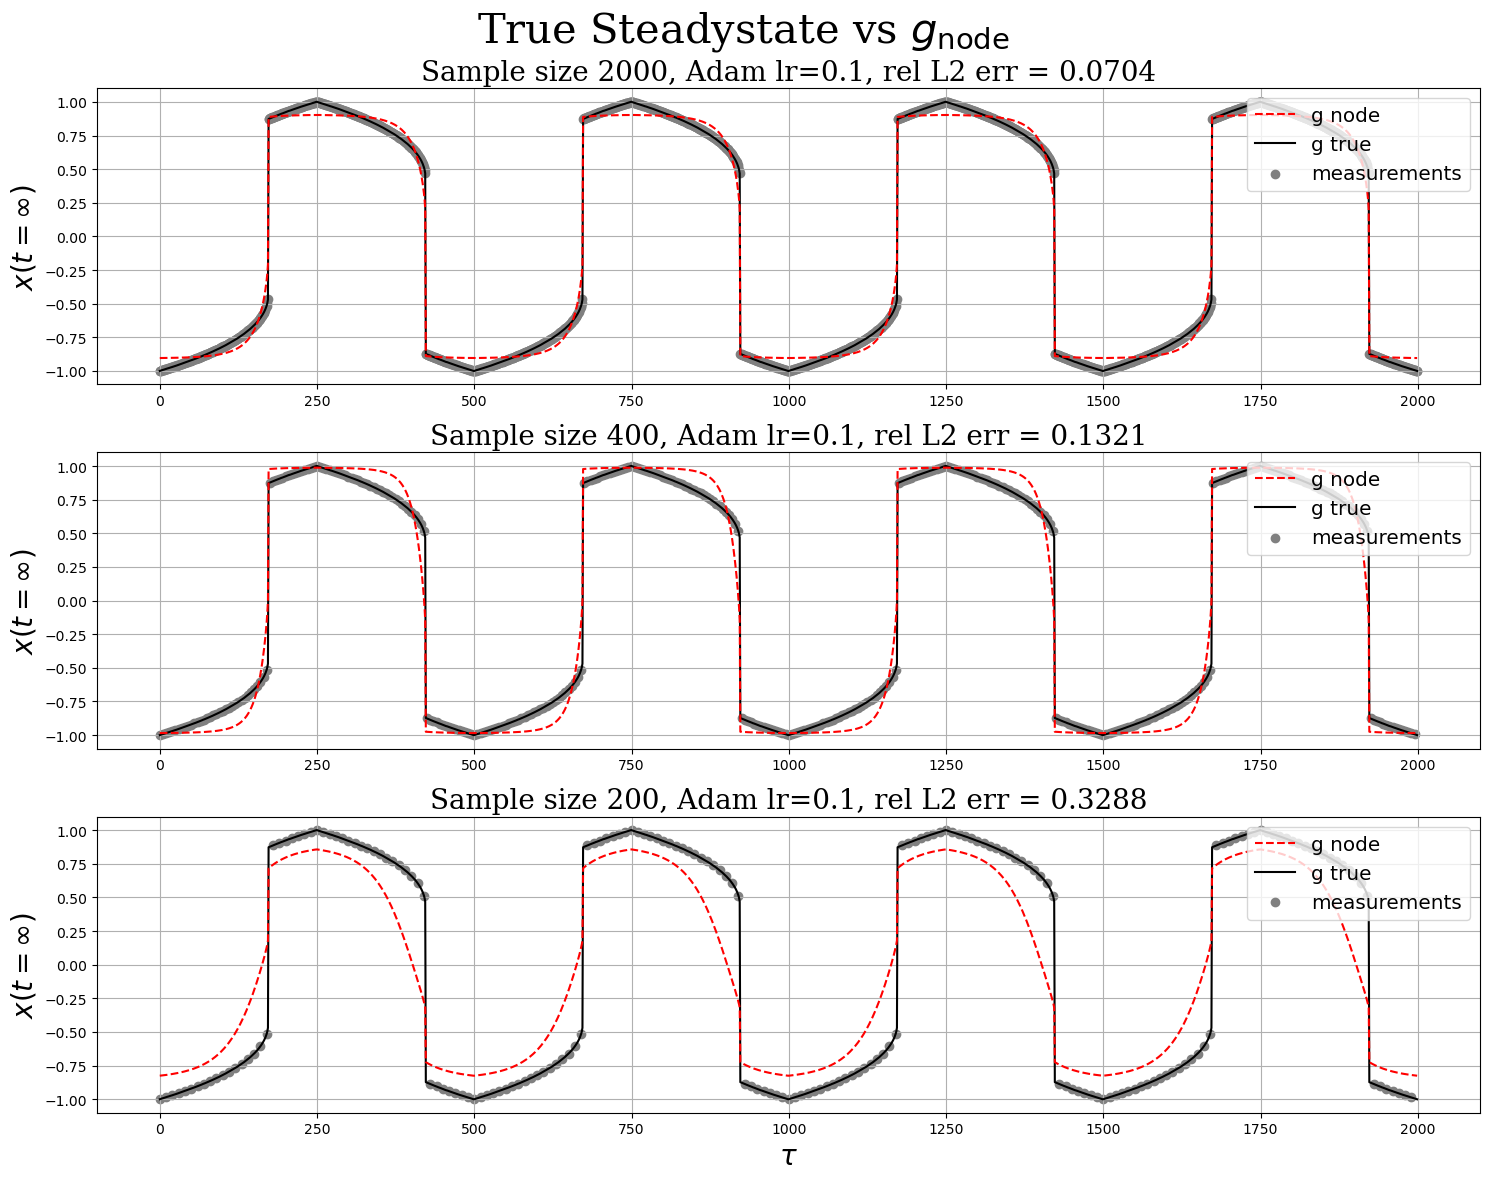

In [49]:
fig, ax  = plt.subplots(3,1,figsize = (15,12))
for idx in range(3):
    ax[idx].plot(pred[idx], linestyle='--', c='red',label='g node', zorder = 5)
    ax[idx].plot(true[idx], label='g true', c='black')
    ax[idx].scatter(tau[idx], train[idx], c='grey', marker='o', label='measurements')
    # plt.plot(X_scaled, label='raw data')
    ax[idx].legend(loc='upper right',fontsize='x-large')
    ax[idx].grid(True)
    ax[idx].set_ylabel(r"$x(t=\infty)$",size=20)
    if idx == 2:
        ax[idx].set_xlabel(r"$\tau$", size=20)
    ax[idx].set_title(f"Sample size {2000//sample_rates[idx]}, Adam lr={lrs[idx]}, rel L2 err = {l2[idx]:.4f}", family='serif',size=20)
plt.suptitle(r"True Steadystate vs $g_{\text{node}}$ ",family='serif', size=30)
plt.tight_layout()
plt.savefig("steady_state_vs_gnode.png")
plt.show()

In [50]:
np.linalg.norm(g_true_scaled - g_pred_out) / np.linalg.norm(g_true_scaled)

0.32880256619084713

## Losses